## Project 2
### Group 3

Project Question

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az
from scipy.stats import linregress
from scipy.stats import gamma
from scipy.stats import multivariate_normal

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Downloading data
df = pd.read_csv("supernovae_redshift.csv")

In [4]:
df.sample(10)

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst
411,0.197,0.1980,21.018,0.118,-0.344,0.302,0.004,0.037,5.000
513,0.013,0.0130,14.883,0.159,-0.925,0.057,0.047,0.021,10.286
213,0.177,0.1780,20.736,0.114,-0.296,0.205,0.025,0.030,9.039
655,0.035,0.0352,16.755,0.145,-0.464,0.120,-0.047,0.045,10.712
165,0.767,0.7680,24.132,0.097,0.906,0.244,-0.119,0.056,9.640
7,0.015,0.0159,15.080,0.154,-0.916,0.069,0.002,0.023,10.662
333,0.148,0.1497,19.741,0.114,-0.845,0.332,-0.155,0.029,10.821
237,0.076,0.0769,18.228,0.112,1.204,0.103,-0.104,0.022,10.732
354,0.155,0.1560,19.970,0.172,-0.197,0.420,-0.122,0.066,10.642
66,0.420,0.4190,22.938,0.088,-0.258,0.174,0.008,0.027,9.609


In [4]:
# defining the nuiscance parameters
alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

In [7]:
# MB
df['MB'] = MB1 + (DeltaM * (df['logMst'] > 10))

# mu
df['dist_moduli'] = df['mb'] - (df['MB'] - alpha * df['x1'] + beta * df['c'])

# distance
df['d'] = pow(10,(df['dist_moduli']/5 + 1))

In [8]:
# distance modulii (mu) error
df['e_mu'] = np.sqrt(df['e_mb'] ** 2 + (alpha * df['e_x1']) ** 2 + (beta * df['e_c']))

# distance error
df['e_d']= (df['e_mu'] * np.log(10) * np.abs(df['d']))/5

In [9]:
# getting only values zcmb < 0.1
corr_df = df[df['zcmb'] < 0.1]
corr_df.describe()

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst,MB,dist_moduli,Distance,e_mu,d,e_d
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,1.520000e+02,152.000000,1.520000e+02,1.520000e+02
mean,0.038625,0.038677,16.704684,0.139704,-0.322553,0.134072,0.000250,0.026868,10.247789,-19.103882,35.762311,1.737721e+08,0.319589,1.737721e+08,2.564739e+07
std,0.023841,0.024271,1.375018,0.015207,1.095961,0.103282,0.081259,0.008219,1.066666,0.029568,1.387712,1.128135e+08,0.038816,1.128135e+08,1.713263e+07
min,0.010000,0.009400,14.148000,0.110000,-2.863000,0.018000,-0.146000,0.012000,5.000000,-19.120000,33.074674,4.120357e+07,0.222590,4.120357e+07,6.331576e+06
25%,0.020750,0.020175,15.738000,0.139000,-1.173500,0.069000,-0.055000,0.022000,10.055750,-19.120000,34.756614,8.939698e+07,0.296019,8.939698e+07,1.290265e+07
50%,0.030000,0.030350,16.645500,0.142000,-0.246500,0.108000,-0.017000,0.025000,10.525500,-19.120000,35.692523,1.375661e+08,0.312716,1.375661e+08,2.017632e+07
75%,0.055000,0.054650,17.807500,0.148000,0.605500,0.175250,0.057750,0.029000,10.842250,-19.120000,36.930773,2.433225e+08,0.333693,2.433225e+08,3.629673e+07
max,0.096000,0.097000,19.773000,0.175000,2.022000,0.782000,0.229000,0.058000,11.381000,-19.050000,38.402242,4.791245e+08,0.455537,4.791245e+08,6.928470e+07


-7741825.3782990575 2052232.8660053909


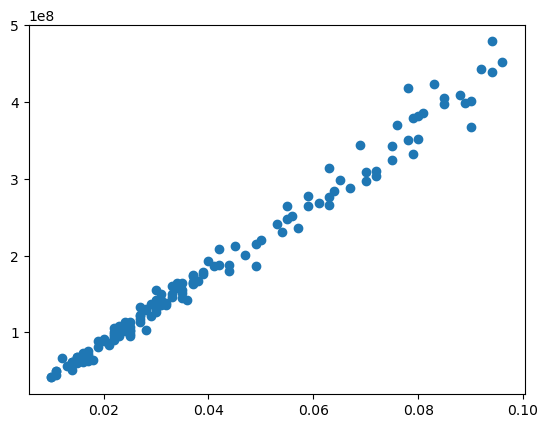

In [11]:
# Creating scatterplots for both redshifts v. magnitude
x = corr_df["zcmb"]
y = corr_df["d"]

plt.scatter(x, y)
result = linregress(x, y)
print(result.intercept, result.intercept_stderr)

/var/folders/d9/xqsb6wp12993hjd0wm68g8h00000gn/T/ipykernel_9943/2807536511.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lam_vector[j] = gamma.rvs(a_gamma, scale=1/b_gamma,size=1)


Text(0, 0.5, 'Standardized residual')

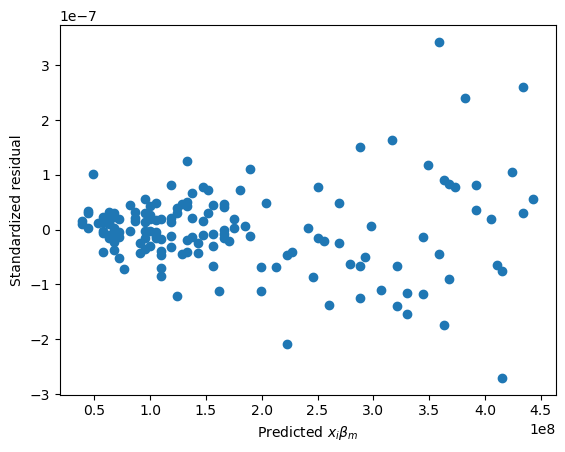

In [12]:
# Sampling and Residual Plot
x = corr_df["zcmb"]
y = corr_df["d"]

ypred = result.intercept + result.slope*x  
res=y-ypred
sse=np.sum((res)**2) 
X = np.matrix([np.ones(x.shape[0]), x]).T

beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
lam_shape = (len(y)-2)/2.

msim=1000
a_gamma = (len(y) - 2)/2.
b_gamma = sse/2.

lam_vector = np.zeros(msim)
beta=np.zeros((msim,2))

for j in range(msim):
    lam_vector[j] = gamma.rvs(a_gamma, scale=1/b_gamma,size=1)
    s_beta = np.linalg.inv(lam_vector[j]*X.T.dot(X))  
    beta[j,:]=multivariate_normal.rvs(mean=np.array([beta_hat[0,0],beta_hat[0,1]]), cov=s_beta, size=1)
    
pred= np.mean(beta[:,0]) + np.mean(beta[:,1]) * x
residuals = y - pred
sr=np.mean(residuals**2)
standardized_residuals = residuals/sr

plt.scatter(pred,standardized_residuals)
plt.xlabel(r'Predicted $x_i\beta_m$')
plt.ylabel(r'Standardized residual')